# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

In [1]:

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

MLFLOW_TRACKING_URI = 'http://localhost:5000'
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

## 1. Exploración de Datos



In [2]:
# Cargo el dataset 
# Uso solo 4 categorías para simplificar
categorias = ['sci.med', 'sci.space', 'rec.sport.baseball', 'comp.graphics']

newsgroups = fetch_20newsgroups(subset='all', categories=categorias, remove=('headers', 'footers', 'quotes'))

# Exploramos el dataset
print(f"Número total de documentos: {len(newsgroups.data)}")
print(f"Número de categorías: {len(newsgroups.target_names)}")
print(f"Categorías: {newsgroups.target_names}")
print(f"\nDistribución de clases:")
for i, cat in enumerate(newsgroups.target_names):
    count = sum(newsgroups.target == i)
    print(f"  {cat}: {count} documentos")

# Mostramos un ejemplo
print(f"\n--- Ejemplo de documento ---")
print(f"Categoría: {newsgroups.target_names[newsgroups.target[0]]}")
print(f"Texto (primeros 500 caracteres):\n{newsgroups.data[0][:500]}...")

Número total de documentos: 3944
Número de categorías: 4
Categorías: ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'sci.space']

Distribución de clases:
  comp.graphics: 973 documentos
  rec.sport.baseball: 994 documentos
  sci.med: 990 documentos
  sci.space: 987 documentos

--- Ejemplo de documento ---
Categoría: sci.med
Texto (primeros 500 caracteres):

A placebo is an accepted treatment at times. 


Why should it?  Placebos are effective under certain circumstances.  That's
why they're used.  

Actually, I don't know know anyone who has actually gotten a "sugar pill".
I don't know how it could be done, since prescription drugs are always
labeled, and it's easy enough to find out what's in a pill if you have the
name.

It's more common to prescribe a drug which is effective for something, just
not for what you have.  Antibiotics for viral infe...


## 2. Preprocesamiento de Texto



In [3]:
# Divido los datos en train y test
X = newsgroups.data
y = newsgroups.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Documentos de entrenamiento: {len(X_train)}")
print(f"Documentos de prueba: {len(X_test)}")

# Configuro los hiperparámetros
n_features = 5000  # Número máximo de features TF-IDF
alpha = 1.0        # Parámetro de suavizado para Naive Bayes

# Creo el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=n_features, stop_words='english')

# Transformo los datos
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nForma de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")

Documentos de entrenamiento: 3155
Documentos de prueba: 789

Forma de X_train_tfidf: (3155, 5000)
Forma de X_test_tfidf: (789, 5000)


## 3. Entrenamiento del Modelo



In [4]:
# Creo el pipeline completo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=n_features, stop_words='english')),
    ('classifier', MultinomialNB(alpha=alpha))
])

# Entreno el modelo
pipeline.fit(X_train, y_train)

print("Modelo entrenado correctamente!")
print(f"Hiperparámetros utilizados:")
print(f"  - max_features (TF-IDF): {n_features}")
print(f"  - alpha (Naive Bayes): {alpha}")

Modelo entrenado correctamente!
Hiperparámetros utilizados:
  - max_features (TF-IDF): 5000
  - alpha (Naive Bayes): 1.0


## 4. Evaluación del Modelo



In [5]:
#  predicciones
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# métricas en train
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# métricas en test
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print("Métricas de Entrenamiento")
print(f"Accuracy:  {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall:    {recall_train:.4f}")
print(f"F1-Score:  {f1_train:.4f}")

print("\nMétricas de Test")
print(f"Accuracy:  {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")

print("\n=== Reporte de Clasificación (Test) ===")
print(classification_report(y_test, y_test_pred, target_names=newsgroups.target_names))

Métricas de Entrenamiento
Accuracy:  0.9376
Precision: 0.9402
Recall:    0.9376
F1-Score:  0.9376

Métricas de Test
Accuracy:  0.8961
Precision: 0.8988
Recall:    0.8961
F1-Score:  0.8959

=== Reporte de Clasificación (Test) ===
                    precision    recall  f1-score   support

     comp.graphics       0.88      0.91      0.90       192
rec.sport.baseball       0.85      0.95      0.90       198
           sci.med       0.94      0.87      0.90       202
         sci.space       0.92      0.85      0.88       197

          accuracy                           0.90       789
         macro avg       0.90      0.90      0.90       789
      weighted avg       0.90      0.90      0.90       789



## 5. Registro de Métricas con MLflow


In [6]:
# Configuro el experimento en MLflow
mlflow.set_experiment('newsgroups-clasificacion')

# Registro el experimento
with mlflow.start_run(run_name='naive-bayes-tfidf'):
    
#Registo hiperparámetros
    mlflow.log_param('vectorizer', 'TfidfVectorizer')
    mlflow.log_param('max_features', n_features)
    mlflow.log_param('classifier', 'MultinomialNB')
    mlflow.log_param('alpha', alpha)
    mlflow.log_param('categorias', str(categorias))
    
# Registro métricas de entrenamiento
    mlflow.log_metric('accuracy_train', accuracy_train)
    mlflow.log_metric('precision_train', precision_train)
    mlflow.log_metric('recall_train', recall_train)
    mlflow.log_metric('f1_train', f1_train)
    
# Registro métricas de test
    mlflow.log_metric('accuracy_test', accuracy_test)
    mlflow.log_metric('precision_test', precision_test)
    mlflow.log_metric('recall_test', recall_test)
    mlflow.log_metric('f1_test', f1_test)
    
# Registro el modelo
    mlflow.sklearn.log_model(pipeline, 'modelo-clasificador')
    
    print("Experimento registrado en MLflow!")
    print(f"Abre http://localhost:5000 para ver los resultados")

2026/02/01 20:34:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento registrado en MLflow!
Abre http://localhost:5000 para ver los resultados
🏃 View run naive-bayes-tfidf at: http://localhost:5000/#/experiments/1/runs/69397622e38745b8891b40a0892d7c6a
🧪 View experiment at: http://localhost:5000/#/experiments/1


## Capturas de MLflow

### 1. Lista de experimentos
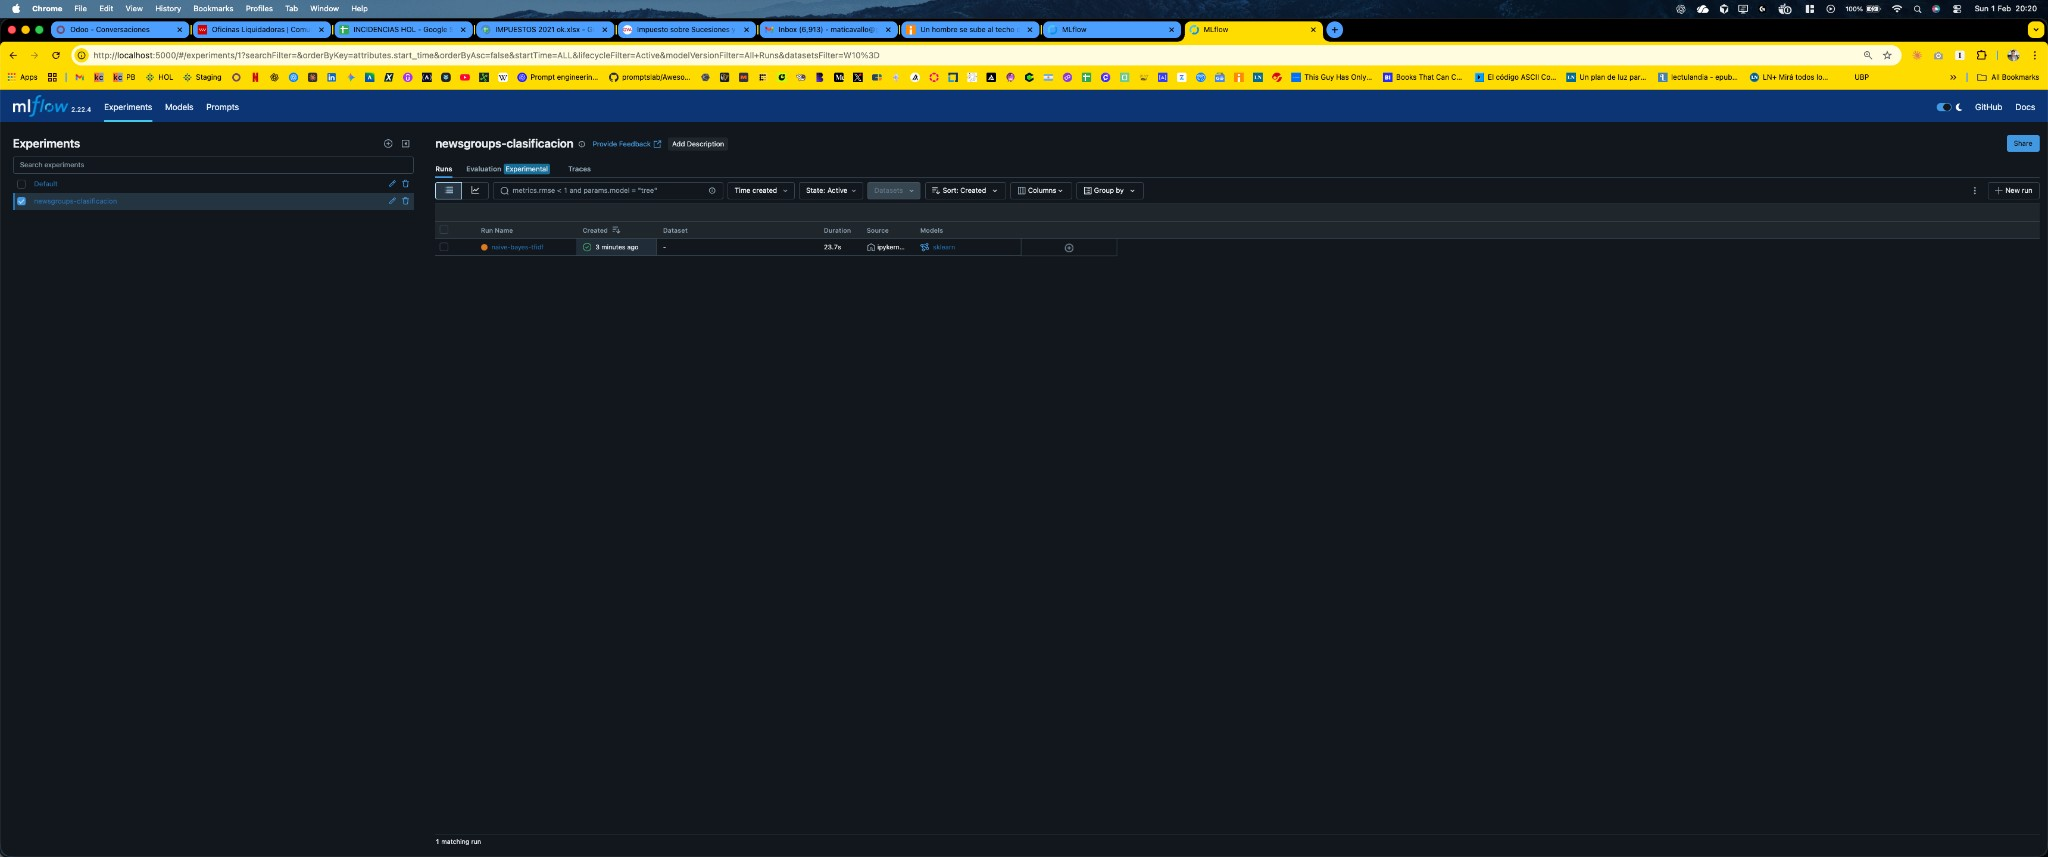

### 2. Parámetros y métricas registrados
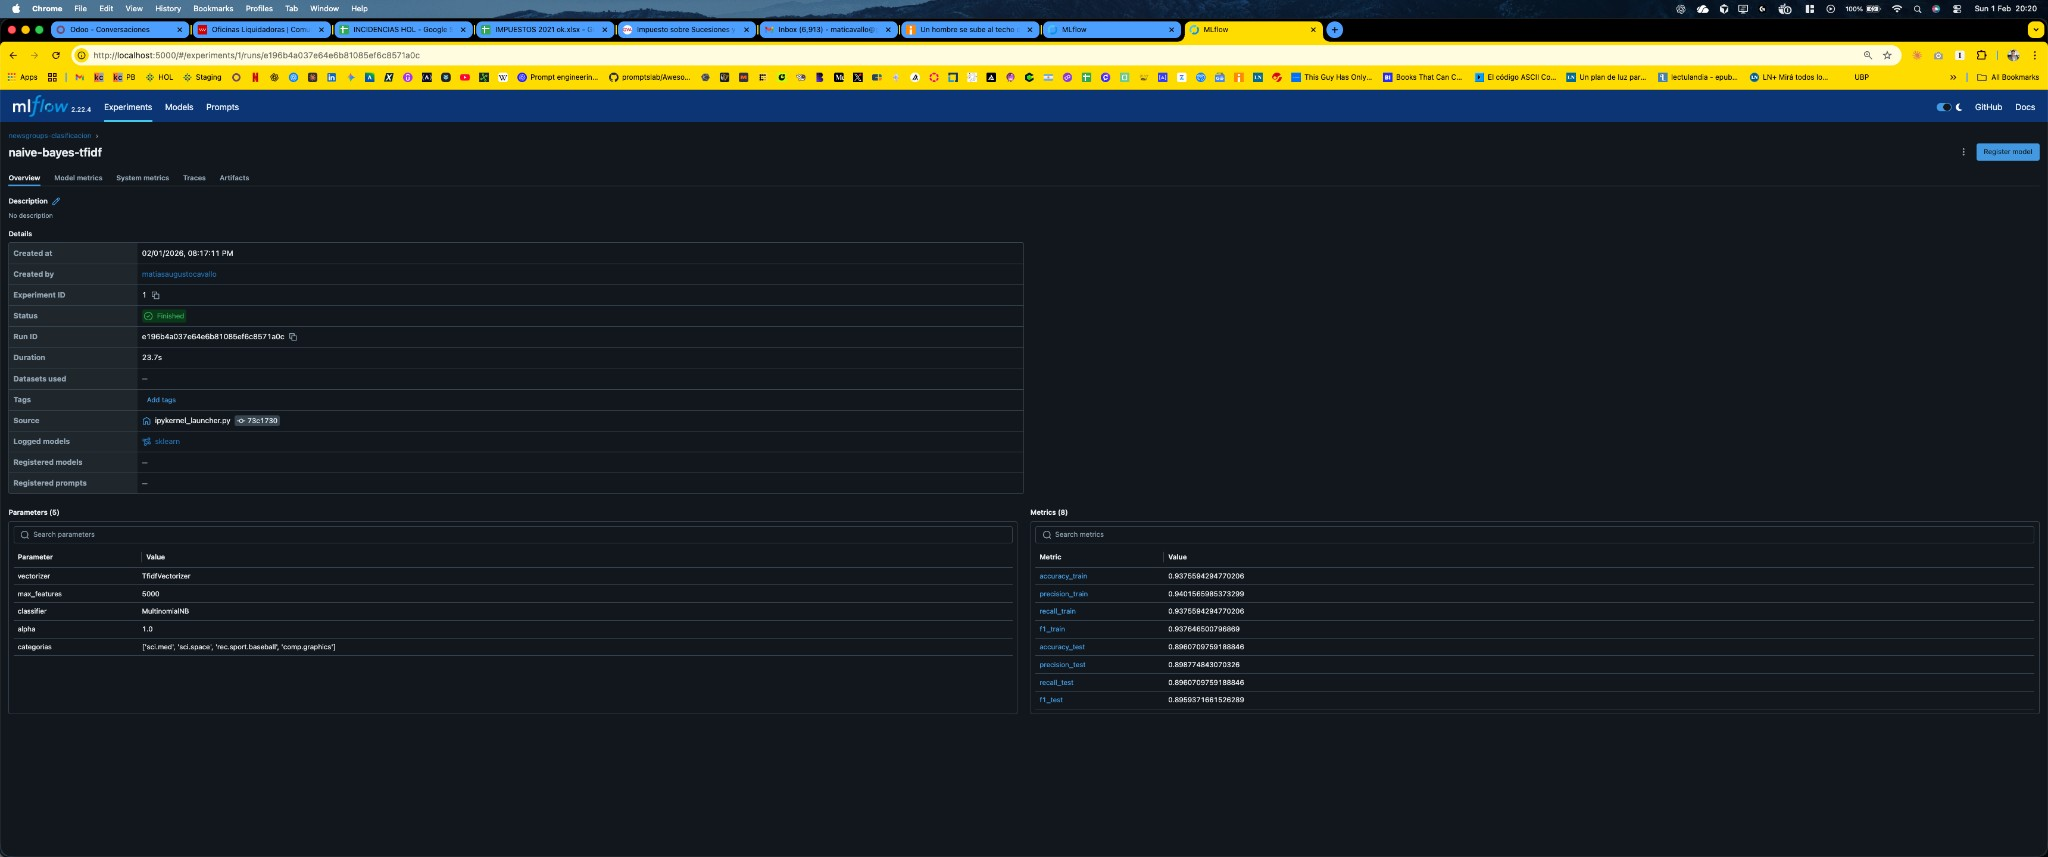

### 3. Métricas en gráficos
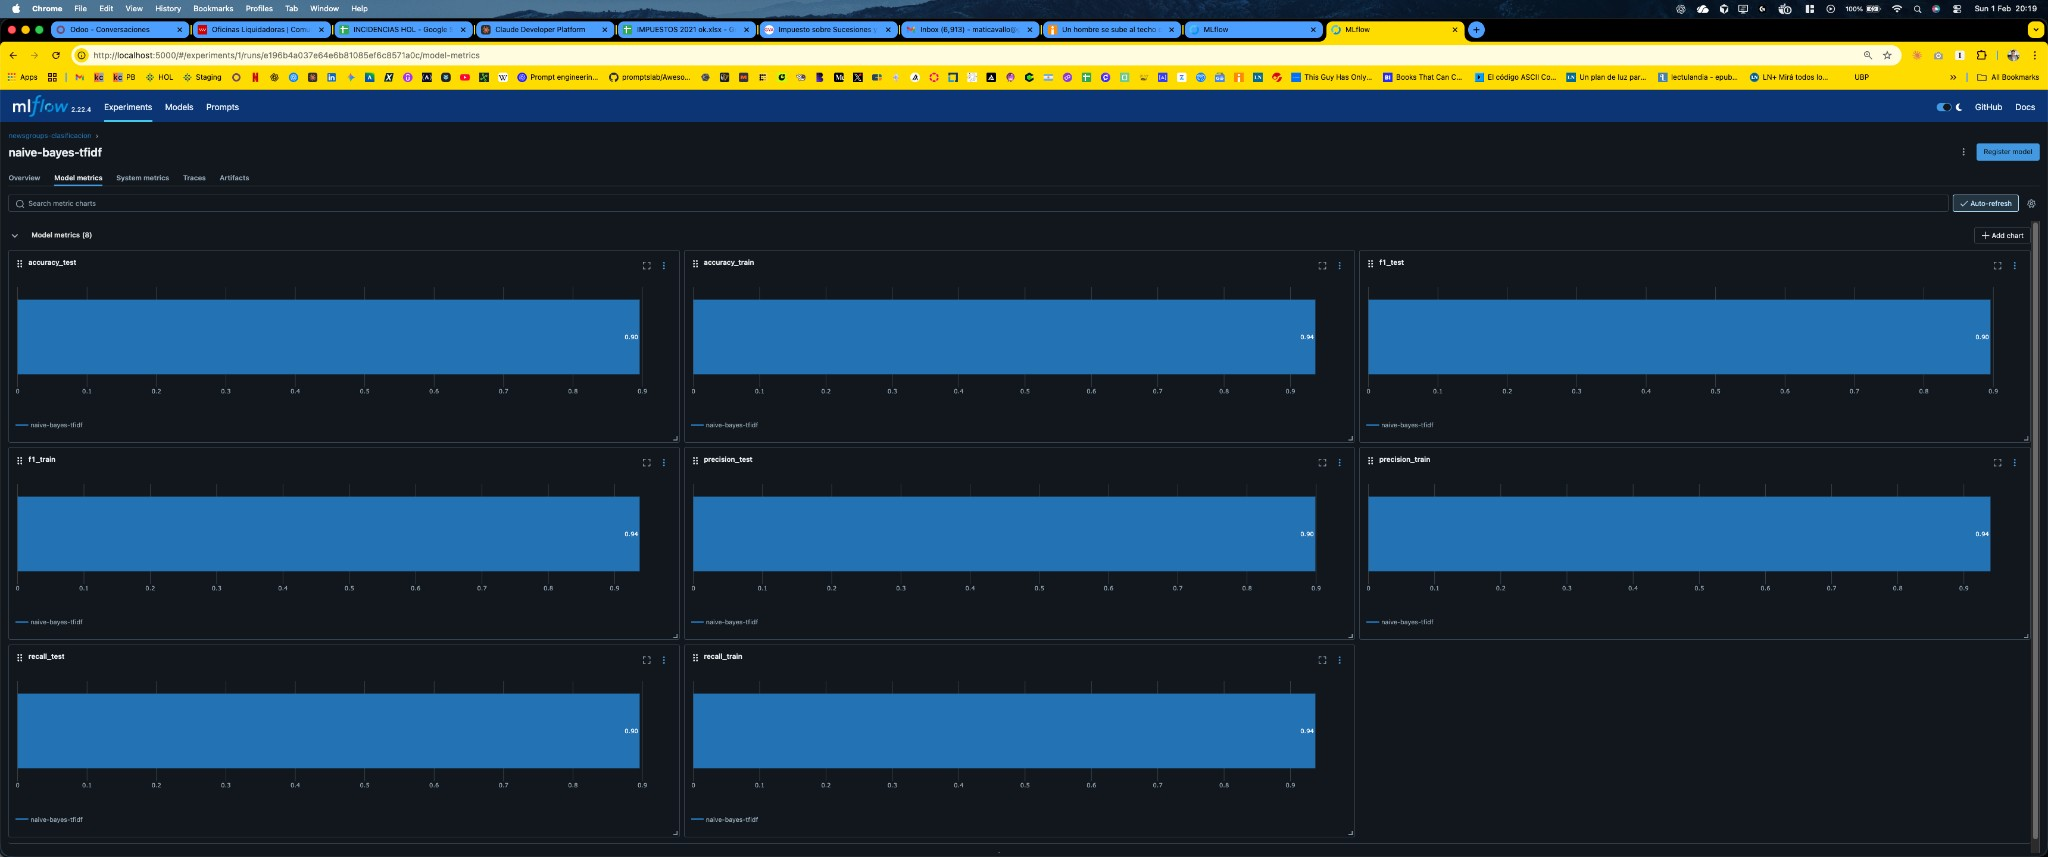

### 4. Modelo guardado (Artifacts)
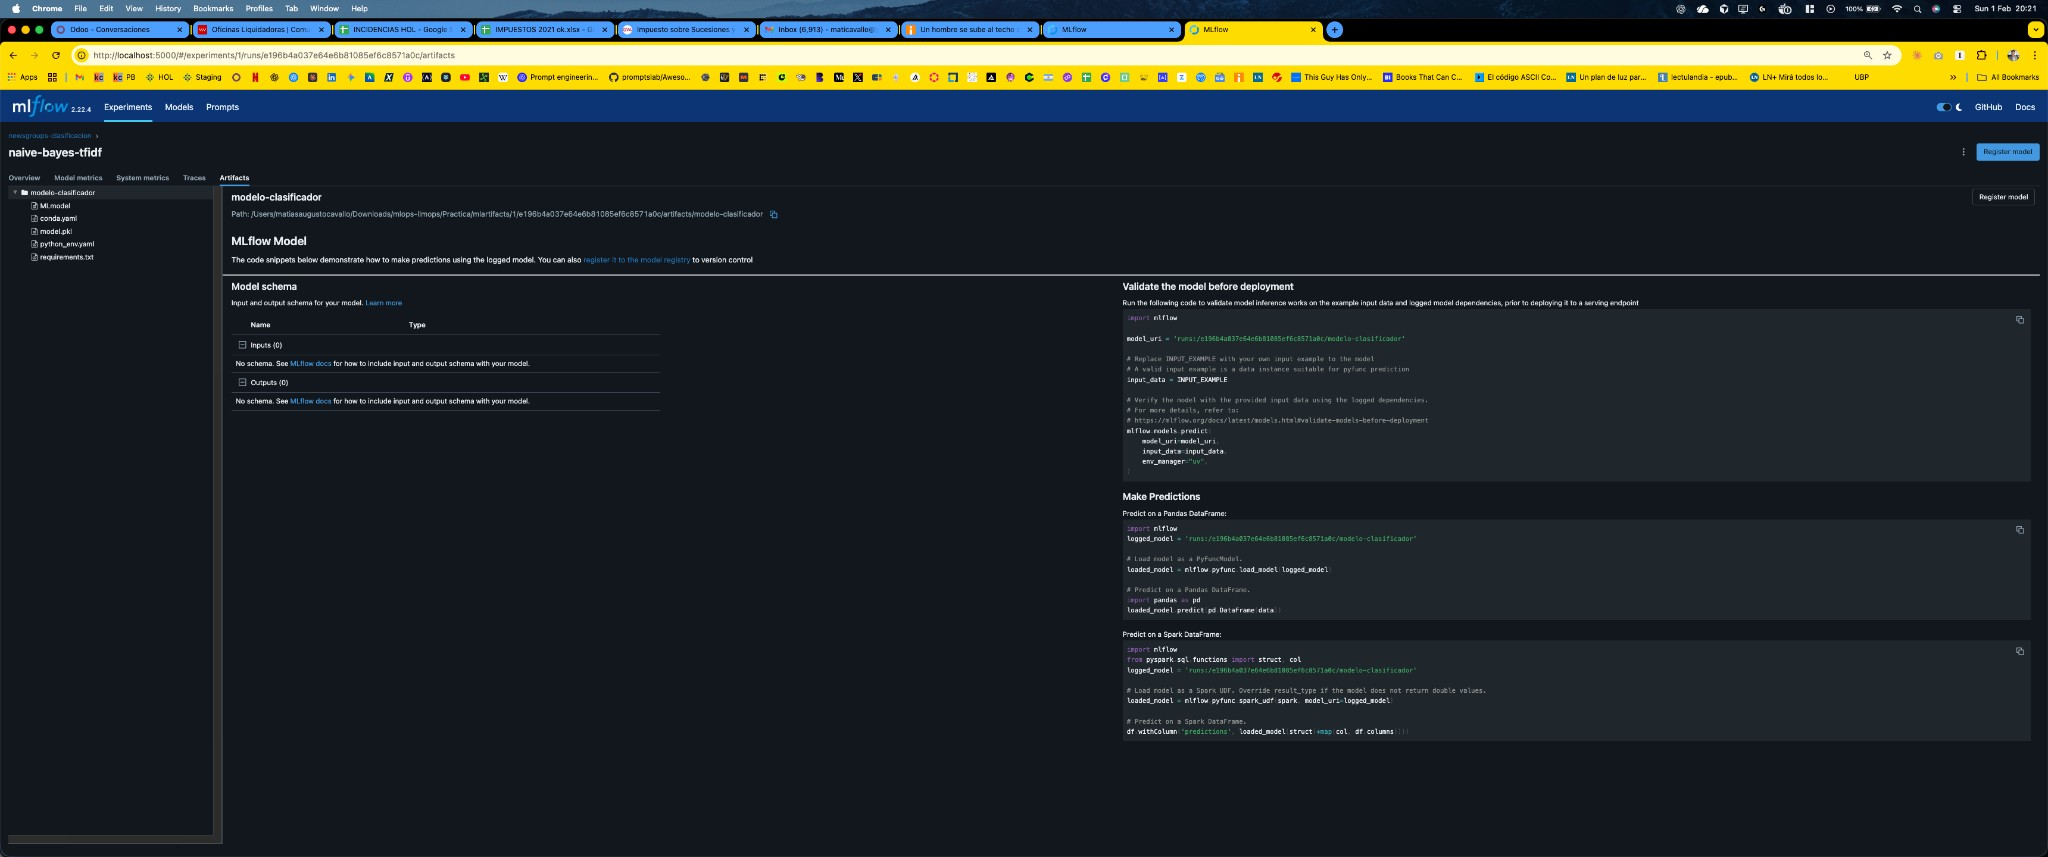

Generar .py de funciones y main con al menos dos argumentos de entrada.


In [ ]:
# funciones.py

import mlflow
import mlflow.sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def cargar_datos(categorias=None, test_size=0.2):
    """Carga el dataset 20newsgroups y lo divide en train/test."""
    if categorias is None:
        categorias = ['sci.med', 'sci.space', 'rec.sport.baseball', 'comp.graphics']
    
    newsgroups = fetch_20newsgroups(subset='all', categories=categorias, 
                                     remove=('headers', 'footers', 'quotes'))
    
    X_train, X_test, y_train, y_test = train_test_split(
        newsgroups.data, newsgroups.target, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test, newsgroups.target_names


def entrenar_modelo(X_train, y_train, n_features=5000, alpha=1.0):
    """Entrena un modelo de clasificación de texto usando TF-IDF y Naive Bayes."""
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=n_features, stop_words='english')),
        ('classifier', MultinomialNB(alpha=alpha))
    ])
    pipeline.fit(X_train, y_train)
    return pipeline




In [ ]:
# main.py

import argparse
import mlflow
import funciones


def main():
    # Se configuran los argumentos de entrada
    parser = argparse.ArgumentParser(
        description='Entrena un modelo de clasificación de texto con 20 Newsgroups'
    )
    
    parser.add_argument(
        '--n_features', 
        type=int, 
        default=5000,
        help='Número máximo de features TF-IDF (default: 5000)'
    )
    
    parser.add_argument(
        '--alpha', 
        type=float, 
        default=1.0,
        help='Parámetro de suavizado para Naive Bayes (default: 1.0)'
    )
    
    # Se parsean los argumentos
    args = parser.parse_args()
    
    print("Clasificación de Texto con 20 Newsgroups")
    print("-" * 45)
    print(f"\nParámetros:")
    print(f"  - n_features: {args.n_features}")
    print(f"  - alpha: {args.alpha}")
    print()
    
    # Se configura MLflow
    MLFLOW_TRACKING_URI = 'http://localhost:5000'
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    
    # 1. Se cargan los datos
    print("1. Cargando datos...")
    X_train, X_test, y_train, y_test, target_names = funciones.cargar_datos()
    print()
    
    # 2. Se entrena el modelo
    print("2. Entrenando modelo...")
    pipeline = funciones.entrenar_modelo(
        X_train, 
        y_train, 
        n_features=args.n_features, 
        alpha=args.alpha
    )
    print()
    
    # 3. Se evalúa el modelo
    print("3. Evaluando modelo...")
    metricas = funciones.evaluar_modelo(pipeline, X_train, X_test, y_train, y_test)
    
    print("\nMétricas de Test:")
    print(f"  - Accuracy:  {metricas['accuracy_test']:.4f}")
    print(f"  - Precision: {metricas['precision_test']:.4f}")
    print(f"  - Recall:    {metricas['recall_test']:.4f}")
    print(f"  - F1-Score:  {metricas['f1_test']:.4f}")
    print()
    
    # 4. Se registra en MLflow
    print("4. Registrando en MLflow...")
    funciones.registrar_en_mlflow(
        pipeline, 
        metricas, 
        args.n_features, 
        args.alpha
    )
    
    print("\nProceso completado!")
    print("Abre http://localhost:5000 para ver los resultados en MLflow")


if __name__ == '__main__':
    main()


'''
output consola:
source venv/bin/activate && python main.py --n_features 5000 --alpha 1.0

Clasificación de Texto con 20 Newsgroups
---------------------------------------------

Parámetros:
  - n_features: 5000
  - alpha: 1.0

1. Cargando datos...
Datos cargados:
  - Documentos de entrenamiento: 3155
  - Documentos de prueba: 789
  - Categorías: ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'sci.space']

2. Entrenando modelo...
Modelo entrenado con:
  - max_features: 5000
  - alpha: 1.0

3. Evaluando modelo...

Métricas de Test:
  - Accuracy:  0.8961
  - Precision: 0.8988
  - Recall:    0.8961
  - F1-Score:  0.8959

4. Registrando en MLflow...
2026/02/01 20:41:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Experimento registrado en MLflow!
🏃 View run nb-features5000-alpha1.0 at: http://localhost:5000/#/experiments/1/runs/266ccb1f7e6b4951847f0f1a6bad0a68
🧪 View experiment at: http://localhost:5000/#/experiments/1

Proceso completado!
'''

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

In [ ]:
#app_fastapi.py

from fastapi import FastAPI
from transformers import pipeline

app = FastAPI(title="API Práctica MLOps")

# Carga de los pipelines de Hugging Face
sentiment_pipeline = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")
summarizer_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

@app.get("/")
def root():
    return {"mensaje": "Bienvenido a la API de Práctica MLOps"}

@app.get("/saluda")
def saludar(nombre: str, apellido: str = ""):
    return {"saludo": f"Hola {nombre} {apellido}!"}

@app.get("/info")
def informacion():
    return {"dataset": "20 Newsgroups", "modelo": "Multinomial Naive Bayes con TF-IDF"}

@app.get("/sentiment")
def analisis_sentimiento(text: str):
    resultado = sentiment_pipeline(text)
    return {"sentimiento": resultado[0]["label"], "confianza": resultado[0]["score"]}

@app.get("/summarize")
def resumir_texto(text: str, max_length: int = 50):
    resultado = summarizer_pipeline(text, max_length=max_length, min_length=20)
    return {"resumen": resultado[0]["summary_text"]}


## Capturas de la API FastAPI

### 1. Endpoint raíz (/)
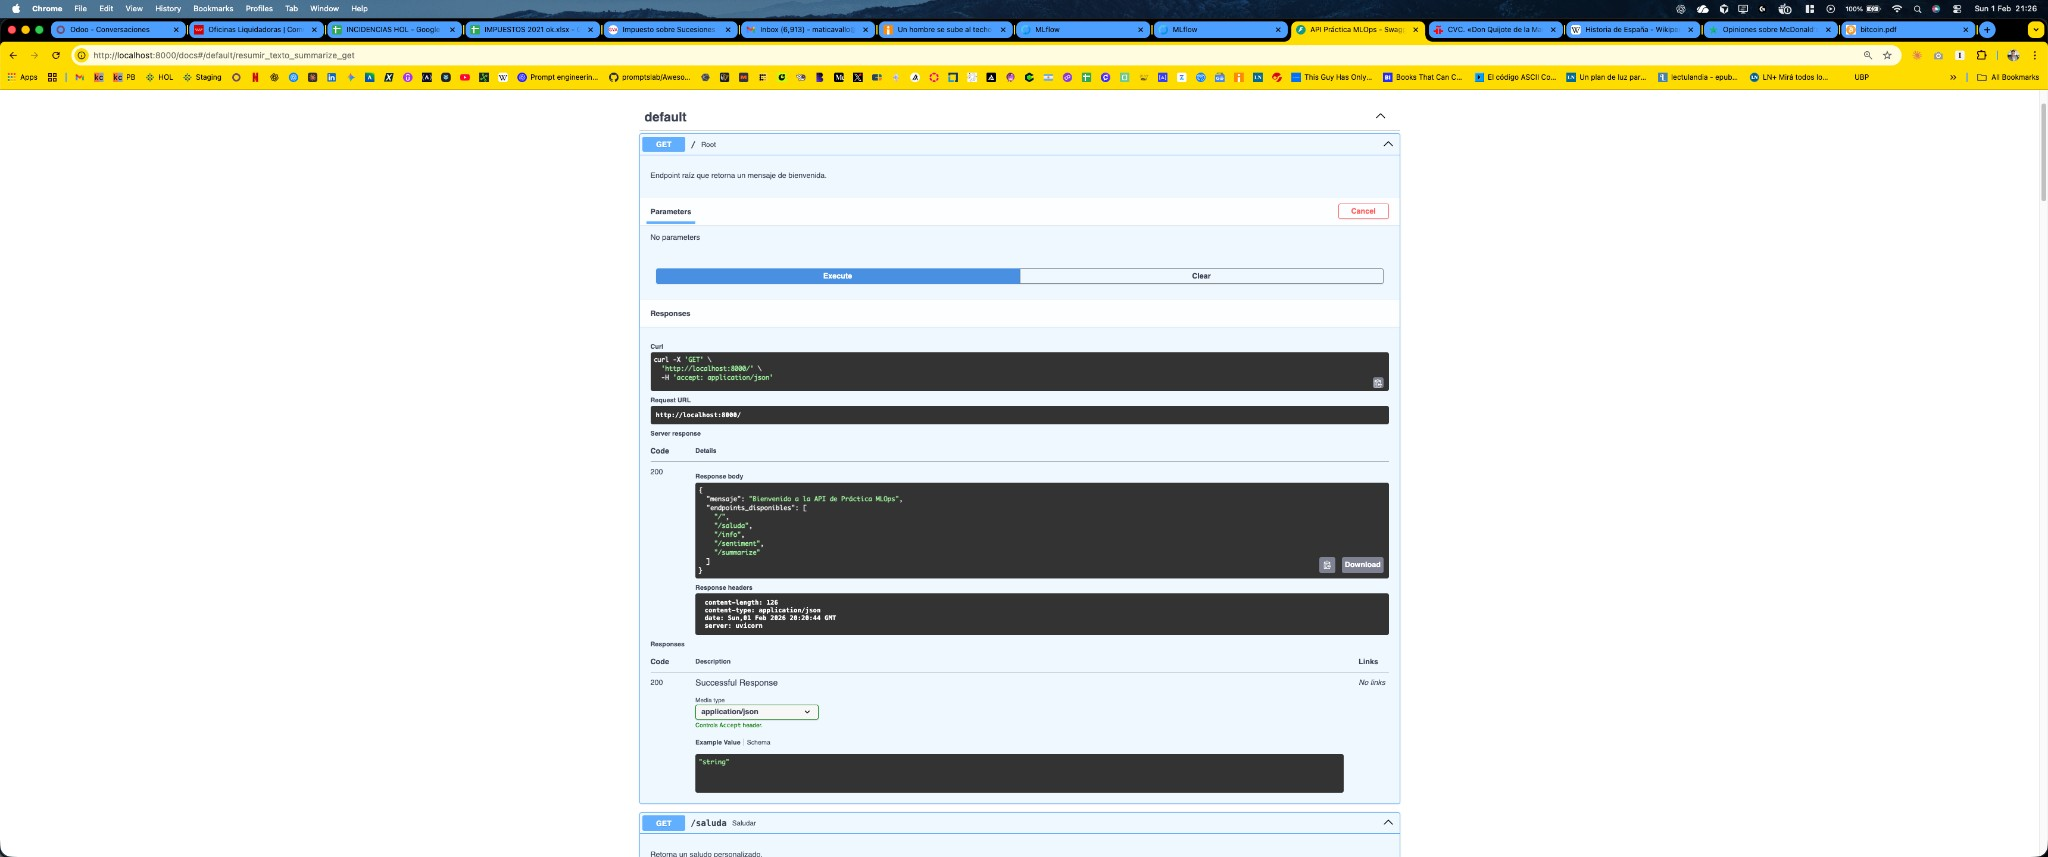

### 2. Endpoint /saluda
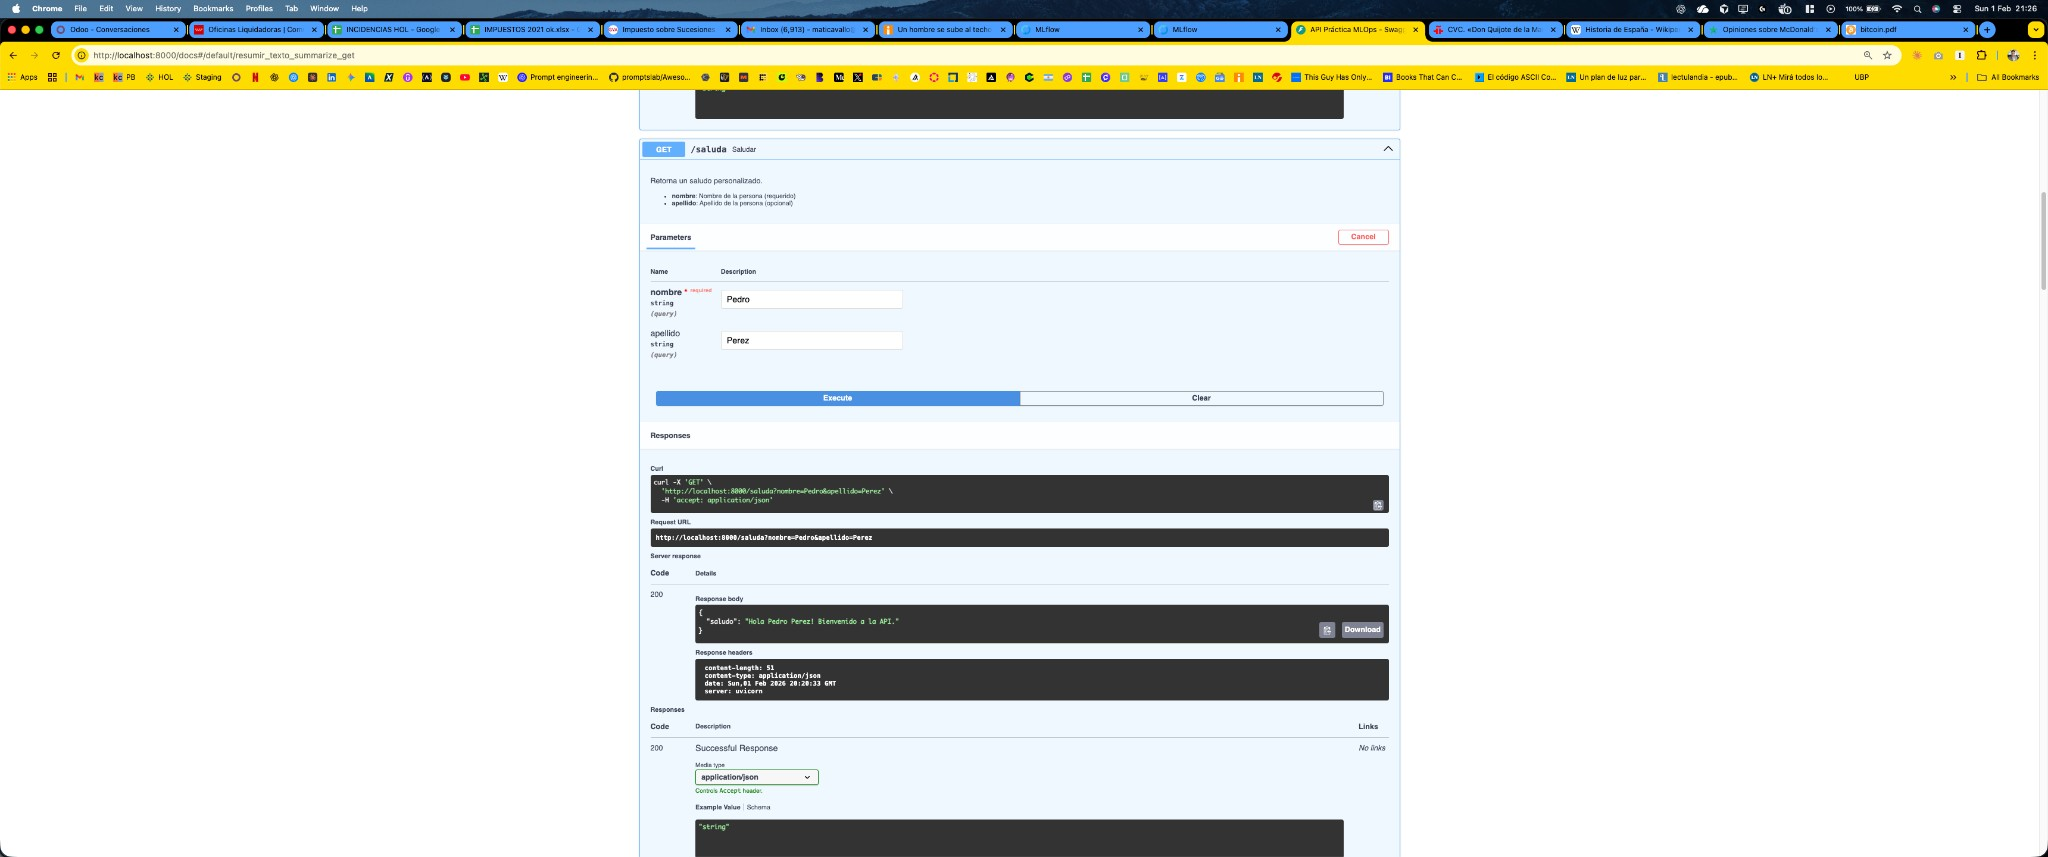

### 3. Endpoint /info
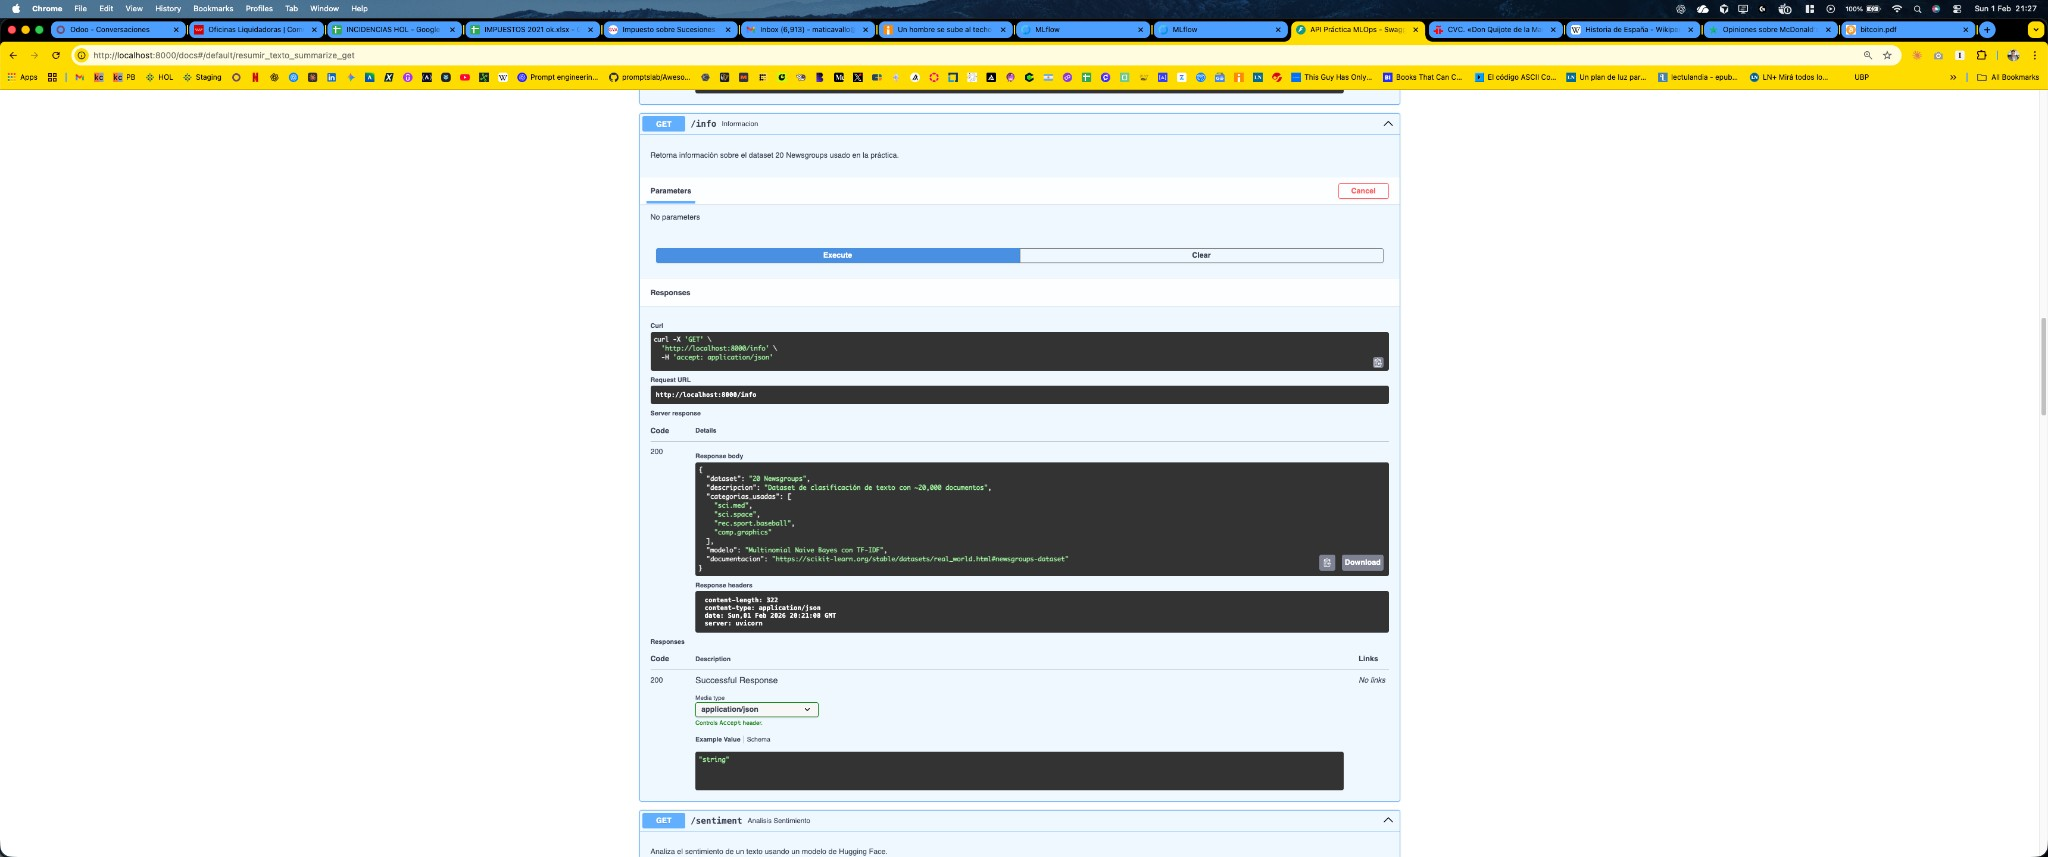

### 4. Endpoint /summarize - Input
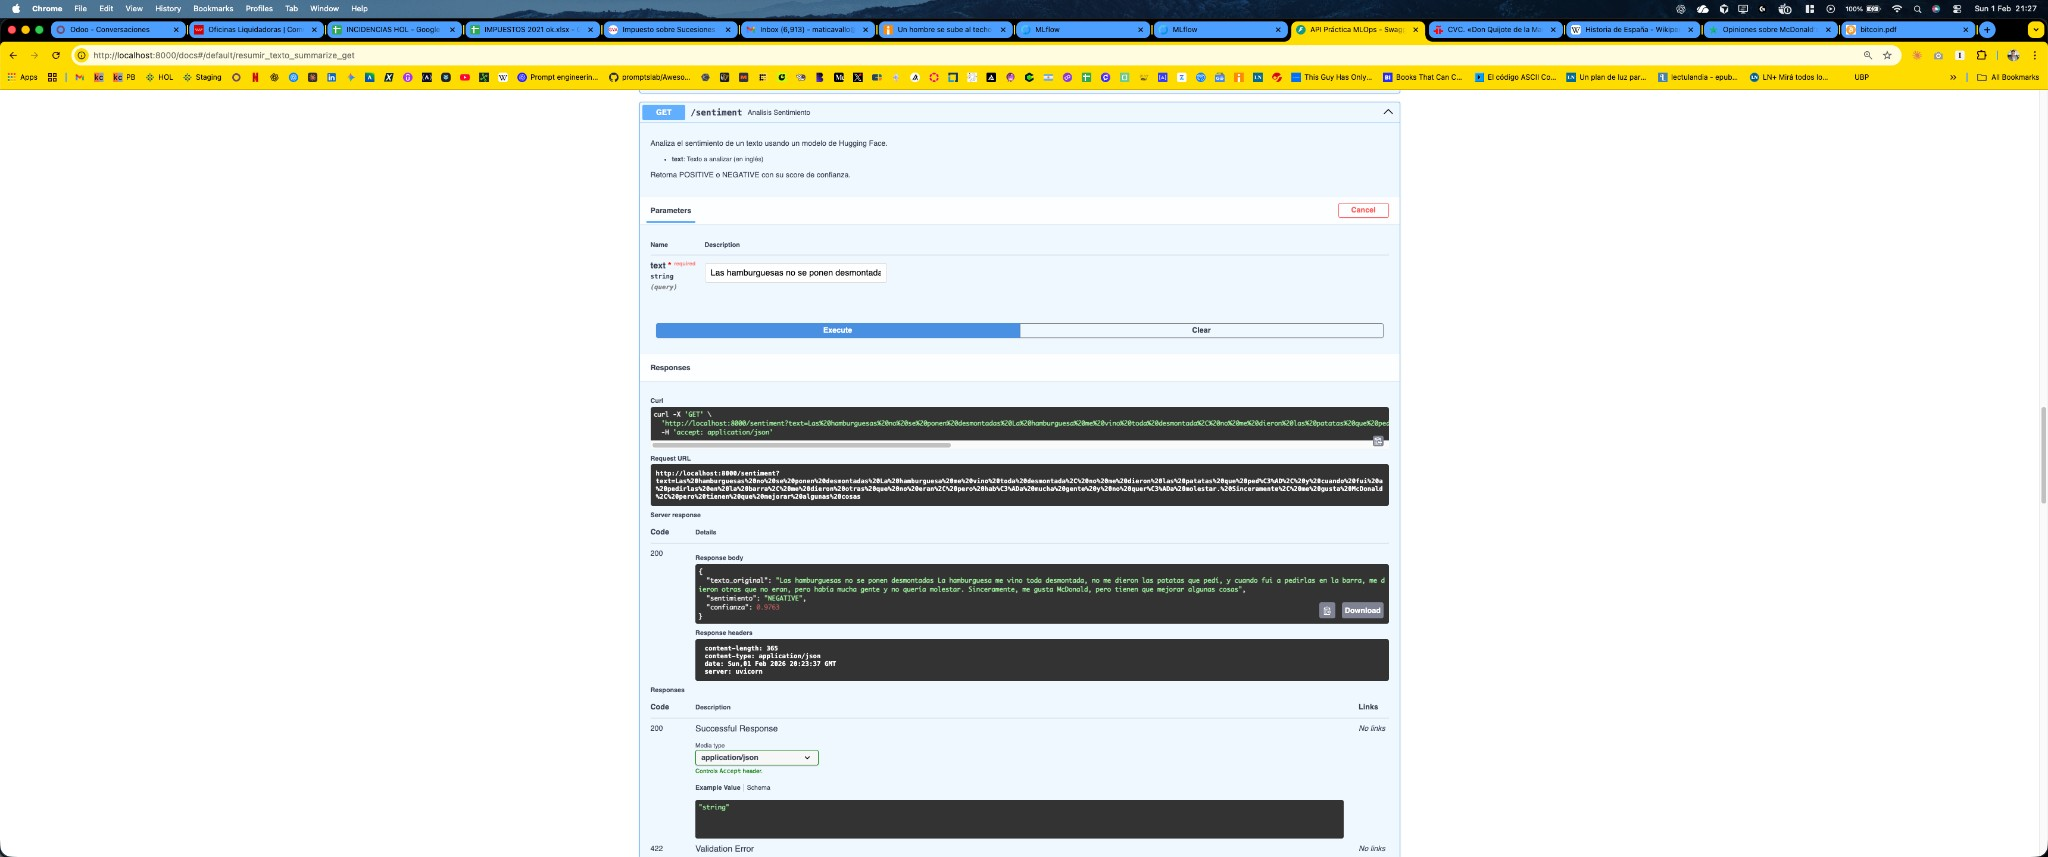

### 5. Endpoint /summarize - Resultado
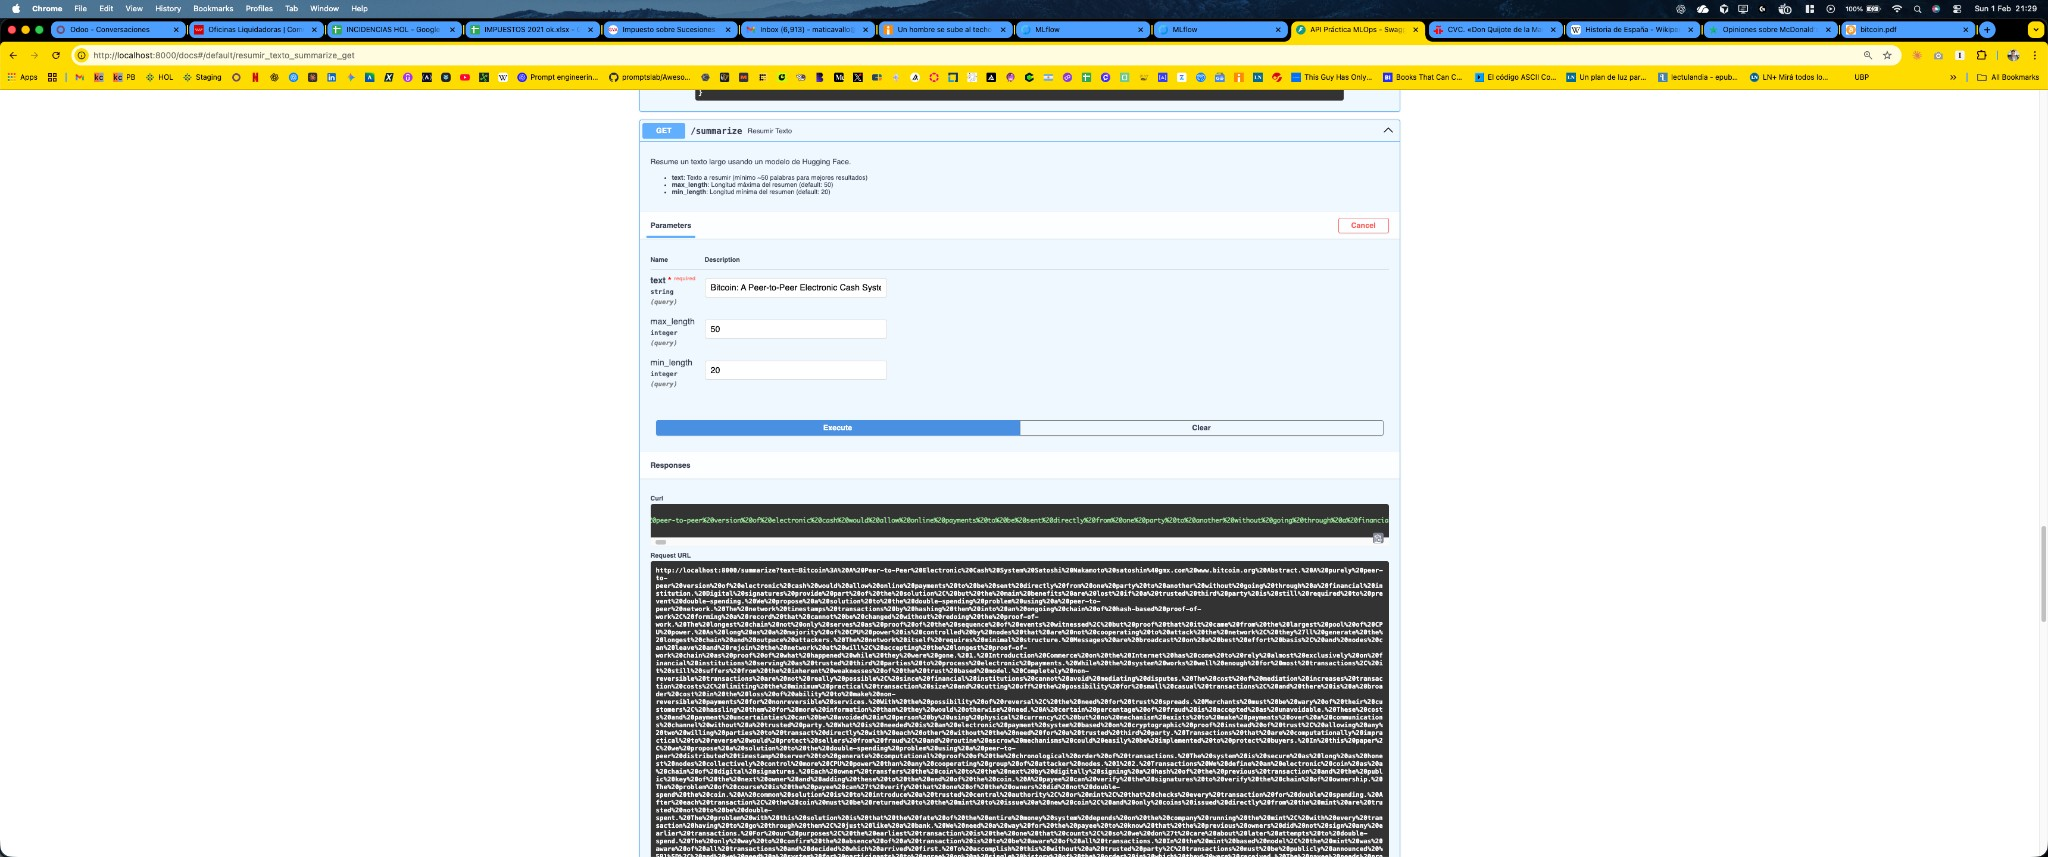

### 6. Endpoint /sentiment
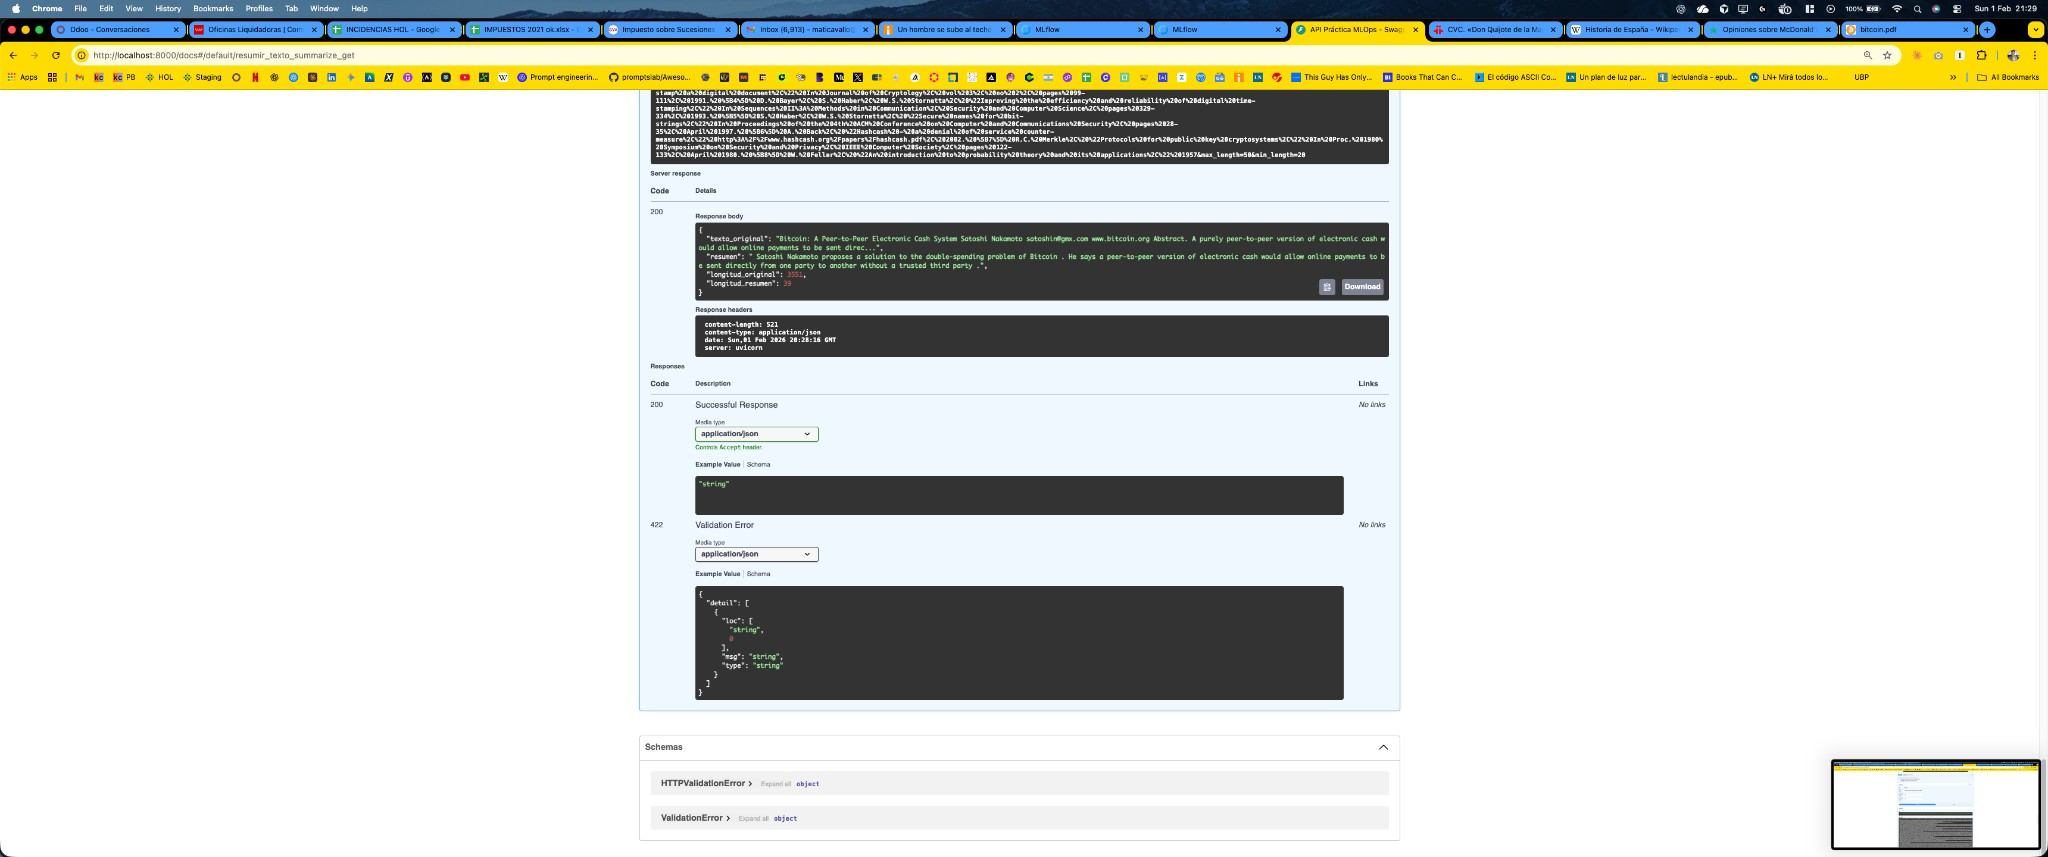

